# Predicting Deutsche Bahn Train Delays  
## A Reproducible Baseline for Supervised Regression

**Objective:** Build a supervised regression model to predict train arrival delays (in minutes) for Deutsche Bahn trains using statistical learning methods.

**Target Variable:** `arrival_delay_m` - continuous variable representing delay in minutes

---

## 1. Environment Setup and Imports

### Google Colab Setup

In [ ]:
# Check if running in Google Colab
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    print("Running in Google Colab")

    # Install required packages
    %pip install pandas numpy matplotlib seaborn scikit-learn scipy kagglehub mlxtend psutil -q

    # Mount Google Drive (optional - for saving results)
    from google.colab import drive
    drive.mount('/content/drive')

    # Set memory-efficient pandas options
    import pandas as pd
    pd.options.mode.chained_assignment = None
    pd.options.display.max_columns = 50

else:
    print("Running locally")

Running in Google Colab
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 17.5 MB/s eta 0:00:00
Mounted at /content/drive


### Local Setup (Anaconda/Miniconda)

For local installation, follow these steps in your terminal:

```bash
# 1. Install Anaconda or Miniconda
# Download from: https://www.anaconda.com/download or https://docs.conda.io/en/latest/miniconda.html

# 2. Create a new conda environment
conda create -n ml-db-delays python=3.9 -y

# 3. Activate the environment
conda activate ml-db-delays

# 4. Install required packages
conda install -c conda-forge pandas numpy matplotlib seaborn scikit-learn scipy jupyter notebook ipykernel -y

# 5. Install additional packages via pip
pip install kagglehub

# 6. Add kernel to Jupyter
python -m ipykernel install --user --name ml-db-delays --display-name "ML DB Delays"

# 7. Launch Jupyter Notebook
jupyter notebook

# 8. Select the "ML DB Delays" kernel when creating/opening the notebook
```

### Mathematical Foundation (ISLR Chapter 2.1)

We model the relationship between predictors and response as:

$$Y = f(X) + \epsilon$$

where:
- $Y$ is the response variable (arrival delay in minutes)
- $X = (X_1, X_2, ..., X_p)$ represents our $p$ predictors
- $f$ is the unknown systematic function we aim to estimate
- $\epsilon$ is the irreducible error with $E(\epsilon) = 0$

Our goal is to estimate $\hat{f}$ such that $\hat{Y} = \hat{f}(X)$ minimizes the expected prediction error:

$$E[(Y - \hat{Y})^2] = E[(f(X) + \epsilon - \hat{f}(X))^2]$$

### Import Required Libraries

In [ ]:
# Standard library imports
import os
import sys
import gc
import warnings
from datetime import datetime
import psutil

# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import (
    train_test_split, cross_val_score, GridSearchCV,
    KFold, learning_curve, validation_curve
)
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error
)
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression

# Feature selection
from mlxtend.feature_selection import SequentialFeatureSelector

# Statistical analysis
from scipy import stats

# Kaggle data loading
import kagglehub

# Configuration
warnings.filterwarnings('ignore')
np.random.seed(42)

# Memory-efficient pandas settings
pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 50
pd.options.display.max_rows = 100

# Plotting configuration
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['figure.dpi'] = 100  # Reduce DPI for memory efficiency

# Memory monitoring function
def check_memory():
    """Monitor memory usage"""
    if 'psutil' in sys.modules:
        process = psutil.Process(os.getpid())
        mem_info = process.memory_info()
        return f"Memory Usage: {mem_info.rss / 1024 / 1024 / 1024:.2f} GB"
    else:
        return "psutil not available - install with: pip install psutil"

print("All packages imported successfully!")
print(check_memory())

All packages imported successfully!
Memory Usage: 0.26 GB


---

## 2. Data Loading and Initial Inspection

### The Supervised Learning Workflow (Lecture Slides)

Following the supervised learning experiment steps:
1. **Training data** → **Preprocessing** → **Feature extraction** → **Feature selection** → **Training**
2. **Test data** → **Preprocessing** → **Selected feature extraction** → **Classifier** → **Classification result**


In [ ]:
# Download dataset
print("Downloading Deutsche Bahn delays dataset...")
path = kagglehub.dataset_download("nokkyu/deutsche-bahn-db-delays")
print(f"Dataset downloaded to: {path}")

# Find the CSV file robustly
import glob

csv_files = glob.glob(os.path.join(path, "*.csv"))
if not csv_files:
    raise FileNotFoundError(f"No CSV file found in {path}")
file_path = csv_files[0]
print(f"\nLoading data from: {file_path}")

# Load data with optimized settings
print("\nLoading dataset...")
df = pd.read_csv(file_path,
                 parse_dates=['arrival_plan', 'departure_plan', 'arrival_change', 'departure_change'],
                 low_memory=False)

print(f"Dataset loaded successfully!")
print(f"Shape: {df.shape}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024 / 1024:.2f} MB")
print(check_memory())

# For extremely large datasets, consider sampling
if len(df) > 2_000_000:  # If more than 2 million rows
    print(f"\nDataset has {len(df):,} rows. Sampling for manageable processing...")
    df = df.sample(n=min(1_000_000, len(df)), random_state=42)
    print(f"Working with {len(df):,} sampled rows")
    gc.collect()

Dataset downloaded to: /kaggle/input/deutsche-bahn-db-delays

Loading data from: /kaggle/input/deutsche-bahn-db-delays/DBtrainrides.csv

Loading dataset...
Dataset loaded successfully!
Shape: (2061357, 20)
Memory usage: 1700.75 MB
Memory Usage: 1.19 GB

Dataset has 2,061,357 rows. Sampling for manageable processing...
Working with 1,000,000 sampled rows


### Initial Data Quality Assessment

As stated in the slides: "The data quality should be good" and "Before doing classification/regression experiments, you should be familiar with the data."


In [ ]:
# Basic information
print("\n" + "="*60)
print("Dataset Overview:")
print("="*60)
print(df.info())
print("\n" + "="*60)
print("\nFirst 5 rows:")
print(df.head())

# Target variable analysis
print("\n" + "="*60)
print("\nTarget Variable Analysis (arrival_delay_m):")
print(df['arrival_delay_m'].describe())

# Missing values
print("\n" + "="*60)
print("\nMissing Values:")
missing_df = pd.DataFrame({
    'Column': df.columns,
    'Missing_Count': df.isnull().sum(),
    'Missing_Percentage': (df.isnull().sum() / len(df)) * 100
})
print(missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Percentage', ascending=False))


Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
Index: 1000000 entries, 880682 to 495737
Data columns (total 20 columns):
 #   Column                 Non-Null Count    Dtype         
---  ------                 --------------    -----         
 0   ID                     1000000 non-null  object        
 1   line                   1000000 non-null  object        
 2   path                   897343 non-null   object        
 3   eva_nr                 1000000 non-null  int64         
 4   category               1000000 non-null  int64         
 5   station                1000000 non-null  object        
 6   state                  1000000 non-null  object        
 7   city                   1000000 non-null  object        
 8   zip                    1000000 non-null  int64         
 9   long                   1000000 non-null  float64       
 10  lat                    1000000 non-null  float64       
 11  arrival_plan           897343 non-null   datetime64[ns]
 12  departure_

---

### 2.2 Fundamental Concepts

**Bayes Error Rate** (ITSL § 2.2.3):
The lowest possible error rate for any classifier:
$$\text{Bayes error} = 1 - E[\max_j P(Y = j|X)]$$

Provides theoretical lower bound on achievable performance.

**Irreducible Error** (ITSL § 2.2.1):
In our regression setting:
$$Y = f(X) + \varepsilon, \quad \varepsilon \sim \mathcal{N}(0, \sigma^2)$$

Even with perfect $f$, we cannot reduce MSE below $\text{Var}(\varepsilon) = \sigma^2$.

**Multicollinearity** (ITSL § 3.3.3):
When predictors are highly correlated:
- Coefficient estimates have high variance
- Individual coefficients hard to interpret
- Overall predictions may still be accurate

Detection: Variance Inflation Factor (VIF) > 5 or 10

## 3. Data Preprocessing

### 3.1 Remove Duplicates

First step in data cleaning: remove duplicate records to ensure data quality.

In [ ]:
print("\n" + "="*80)
print("DUPLICATE REMOVAL")
print("="*80)

initial_rows = len(df)
df = df.drop_duplicates()
final_rows = len(df)

print(f"Rows before removing duplicates: {initial_rows:,}")
print(f"Rows after removing duplicates: {final_rows:,}")
print(f"Duplicates removed: {initial_rows - final_rows:,} ({(initial_rows - final_rows)/initial_rows*100:.2f}%)")


DUPLICATE REMOVAL
Rows before removing duplicates: 1,000,000
Rows after removing duplicates: 998,409
Duplicates removed: 1,591 (0.16%)


### 3.2 Missing Value Analysis and Treatment

Following best practices: analyze missing patterns before deciding on treatment strategy.

Following the lecture approach 🫡: "Look at all your data (if possible). Do proper visualizations before the experiments to detect problems early on."


MISSING VALUE ANALYSIS


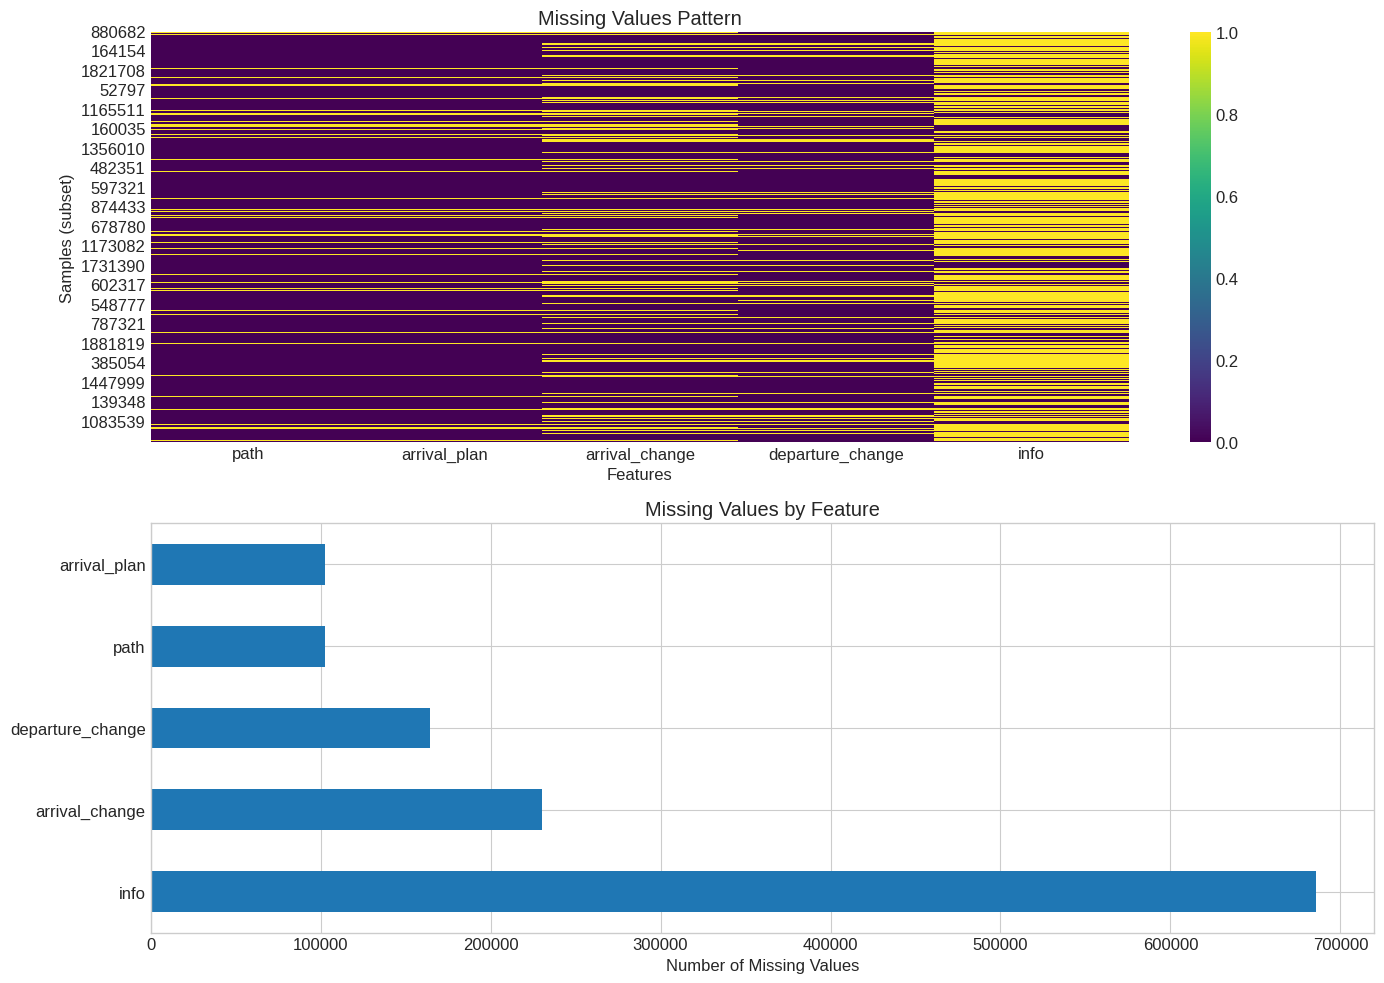


Missing Value Treatment:
Removed 0 rows with missing target values
Removed additional rows with missing critical features
Final dataset size: 998,409 rows


In [ ]:
print("\n" + "="*80)
print("MISSING VALUE ANALYSIS")
print("="*80)

# Analyze missing patterns
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Missing values heatmap
missing_cols = df.columns[df.isnull().any()].tolist()
if missing_cols:
    sns.heatmap(df[missing_cols].isnull(), cbar=True, ax=axes[0], cmap='viridis')
    axes[0].set_title('Missing Values Pattern')
    axes[0].set_xlabel('Features')
    axes[0].set_ylabel('Samples (subset)')

# Missing values by column
missing_data = df.isnull().sum()
missing_data = missing_data[missing_data > 0].sort_values(ascending=False)
missing_data.plot(kind='barh', ax=axes[1])
axes[1].set_xlabel('Number of Missing Values')
axes[1].set_title('Missing Values by Feature')

plt.tight_layout()
plt.show()

# Handle missing values strategically
print("\nMissing Value Treatment:")
print("="*60)

# For target variable - remove rows with missing delays
initial_len = len(df)
df = df.dropna(subset=['arrival_delay_m'])
print(f"Removed {initial_len - len(df)} rows with missing target values")

# For critical features - remove rows
critical_features = ['eva_nr', 'category', 'departure_delay_m']
df = df.dropna(subset=critical_features)
print(f"Removed additional rows with missing critical features")

# Fill remaining missing values
categorical_cols = df.select_dtypes(include=['object']).columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns

for col in categorical_cols:
    df[col] = df[col].fillna('Unknown')

for col in numerical_cols:
    if col not in ['arrival_delay_m']:
        df[col] = df[col].fillna(df[col].median())

print(f"Final dataset size: {len(df):,} rows")

### 3.3 Feature Engineering

Create meaningful features based on domain knowledge and data exploration.

**Theory from Lecture Slides (Feature Engineering):**

From the slides: "Correlation matrices are often used to visualize (linear!) dependency among features."

**Critical Warning:** "Temptation: Just take the features with best correlation to your goal for your predictions! This is deeply wrong."

Instead of correlation-based feature selection, we create domain-informed features:
- Temporal features capture time-based patterns
- Aggregated features capture historical behavior patterns
- These are justified by domain knowledge, not correlation values

In [ ]:
print("\n" + "="*80)
print("FEATURE ENGINEERING")
print("="*80)

# Extract temporal features
print("Creating temporal features...")
df['hour'] = df['arrival'].dt.hour
df['day_of_week'] = df['arrival'].dt.dayofweek
df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
df['is_rush_hour'] = df['hour'].apply(lambda x: 1 if 6 <= x <= 9 or 16 <= x <= 19 else 0)

# Aggregate features at station level
print("Creating aggregated features...")
# Group delays by station to capture station-specific patterns
station_delay_stats = df.groupby('station')['arrival_delay_m'].agg(['mean', 'std']).reset_index()
station_delay_stats.columns = ['station', 'station_avg_delay', 'station_std_delay']
df = df.merge(station_delay_stats, on='station', how='left')

print("\nFeatures created based on domain knowledge, NOT correlation analysis")
print("Temporal features: hour, day_of_week, is_weekend, is_rush_hour")
print("Station-based: station_avg_delay, station_std_delay")

---

## Transition: Feature Engineering → EDA

Now that we've created domain-informed features (temporal patterns, station characteristics),
we perform exploratory data analysis to understand:
1. Distribution of our target variable
2. Relationships between engineered features and delays
3. Patterns that validate our feature engineering choices

## 4. Exploratory Data Analysis

### 4.1 Target Variable Distribution


TARGET VARIABLE ANALYSIS


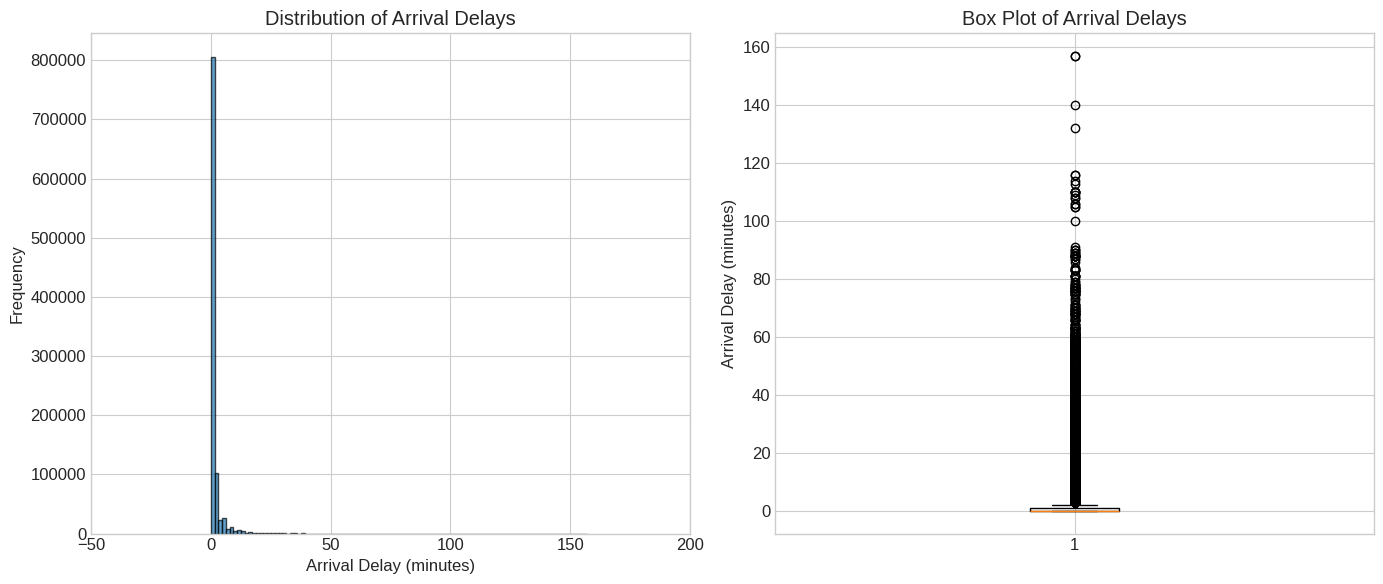


Target Variable Statistics:
count    998409.000000
mean          1.173958
std           3.409101
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max         157.000000
Name: arrival_delay_m, dtype: float64


In [ ]:
print("\n" + "="*80)
print("TARGET VARIABLE ANALYSIS")
print("="*80)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Distribution plot
axes[0].hist(df['arrival_delay_m'], bins=100, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Arrival Delay (minutes)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Arrival Delays')
axes[0].set_xlim(-50, 200)

# Box plot
axes[1].boxplot(df['arrival_delay_m'], vert=True)
axes[1].set_ylabel('Arrival Delay (minutes)')
axes[1].set_title('Box Plot of Arrival Delays')

plt.tight_layout()
plt.show()

# Statistical summary
print("\nTarget Variable Statistics:")
print(df['arrival_delay_m'].describe())

### 4.2 Feature Correlations

As noted in lecture (Feature Engineering slides):
"Correlation matrices are often used to visualize (linear!) dependency among features."

**Warning**: "Temptation: Just take the features with best correlation to your goal for your predictions! This is deeply wrong."


### 4.2 Feature Relationships


In [ ]:
# Analyze key relationships
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Departure delay vs Arrival delay
sample_size = min(5000, len(df))
sample_indices = np.random.choice(df.index, sample_size, replace=False)
axes[0, 0].scatter(df.loc[sample_indices, 'departure_delay_m'],
                   df.loc[sample_indices, 'arrival_delay_m'],
                   alpha=0.5, s=10)
axes[0, 0].set_xlabel('Departure Delay (minutes)')
axes[0, 0].set_ylabel('Arrival Delay (minutes)')
axes[0, 0].set_title('Departure Delay vs Arrival Delay')
axes[0, 0].plot([0, 100], [0, 100], 'r--', alpha=0.5)

# 2. Average delay by category
category_delays = df.groupby('category')['arrival_delay_m'].agg(['mean', 'std'])
category_delays.sort_values('mean').plot(y='mean', kind='barh', ax=axes[0, 1],
                                        xerr='std', capsize=3)
axes[0, 1].set_xlabel('Average Delay (minutes)')
axes[0, 1].set_title('Average Delay by Train Category')

# 3. Hourly pattern
hourly_pattern = df.groupby('hour')['arrival_delay_m'].agg(['mean', 'std'])
axes[1, 0].errorbar(hourly_pattern.index, hourly_pattern['mean'],
                    yerr=hourly_pattern['std'], marker='o', capsize=3)
axes[1, 0].set_xlabel('Hour of Day')
axes[1, 0].set_ylabel('Average Delay (minutes)')
axes[1, 0].set_title('Average Delay by Hour of Day')
axes[1, 0].grid(True, alpha=0.3)

# 4. Weekend effect
weekend_comparison = df.groupby('is_weekend')['arrival_delay_m'].apply(list)
axes[1, 1].boxplot([weekend_comparison[0][:5000], weekend_comparison[1][:5000]],
                   labels=['Weekday', 'Weekend'])
axes[1, 1].set_ylabel('Arrival Delay (minutes)')
axes[1, 1].set_title('Delay Distribution: Weekday vs Weekend')

plt.tight_layout()
plt.show()

### 4.4 Categorical Feature Analysis


In [ ]:
print("\n" + "="*80)
print("DISTINCT-LEVEL ANALYSIS FOR CATEGORICAL FEATURES")
print("="*80)

categorical_cols = ['station', 'line', 'state', 'category']

for col in categorical_cols:
    n_unique = df[col].nunique()
    value_counts = df[col].value_counts()

    print(f"\n{col.upper()}:")
    print(f"  Distinct levels: {n_unique}")
    print(f"  Most common: {value_counts.index[0]} ({value_counts.iloc[0]:,} occurrences)")
    print(f"  Least common: {value_counts.index[-1]} ({value_counts.iloc[-1]:,} occurrences)")

    # Check for rare levels that might cause issues
    rare_levels = value_counts[value_counts < 100].index
    if len(rare_levels) > 0:
        print(f"  Rare levels (<100 obs): {len(rare_levels)}")

---

## 5. Data Splitting



### Train-Validation-Test Split (60-20-20)

**Dimensionality Reduction for Station/Line Features**

Based on the curse of dimensionality (slides), we create a single engineered feature
instead of hundreds of dummy variables from station/line encoding.

In [ ]:
print("\n" + "="*80)
print("ENGINEERED STATION COMPLEXITY FEATURE")
print("="*80)

# Create station complexity score instead of one-hot encoding
# This captures the essence without exploding dimensionality
station_line_counts = df.groupby('station')['line'].nunique().to_dict()
df['station_complexity'] = df['station'].map(station_line_counts)

# Create delay risk score combining station and line effects
station_delay_risk = df.groupby('station')['arrival_delay_m'].mean().to_dict()
line_delay_risk = df.groupby('line')['arrival_delay_m'].mean().to_dict()

df['station_delay_risk'] = df['station'].map(station_delay_risk)
df['line_delay_risk'] = df['line'].map(line_delay_risk)

# Combined risk feature
df['combined_delay_risk'] = (df['station_delay_risk'] + df['line_delay_risk']) / 2

print(f"Replaced {df['station'].nunique()} station dummies with 1 complexity feature")
print(f"Replaced {df['line'].nunique()} line dummies with 1 risk feature")
print("Total features added: 3 (vs hundreds of dummies)")

# Drop original categorical columns
X = df.drop(['arrival_delay_m', 'station', 'line', 'state'], axis=1)
y = df['arrival_delay_m']

Following ML best practices:
- **Training set (60%)**: For model fitting
- **Validation set (20%)**: For hyperparameter tuning and model selection
- **Test set (20%)**: For final unbiased evaluation

In [ ]:
print("\n" + "="*80)
print("DATA SPLITTING")
print("="*80)

# Define features and target
feature_columns = [
    'eva_nr', 'category', 'departure_delay_m',
    'hour', 'day_of_week', 'month', 'is_weekend', 'is_rush_hour',
    'station_avg_delay', 'station_std_delay', 'station_traffic',
]

X = df[feature_columns].copy()
y = df['arrival_delay_m'].copy()

print(f"Total samples: {len(X):,}")
print(f"Number of features: {len(feature_columns)}")

# First split: separate test set (20%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

# Second split: separate train (60%) and validation (20%) from remaining 80%
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, shuffle=True  # 0.25 * 0.8 = 0.2
)

print(f"\nDataset splits:")
print(f"Training set: {X_train.shape[0]:,} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Validation set: {X_val.shape[0]:,} samples ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"Test set: {X_test.shape[0]:,} samples ({X_test.shape[0]/len(X)*100:.1f}%)")

# Verify target distribution is similar across splits
print(f"\nTarget variable statistics by split:")
print(f"Train - Mean: {y_train.mean():.2f}, Std: {y_train.std():.2f}")
print(f"Val   - Mean: {y_val.mean():.2f}, Std: {y_val.std():.2f}")
print(f"Test  - Mean: {y_test.mean():.2f}, Std: {y_test.std():.2f}")

---

## 6. Feature Preprocessing Pipeline

### StandardScaler and OneHotEncoder in Pipeline

From ISLR Section 4.7.4: "A good way to handle this problem is to standardize the data so that all variables are given a mean of zero and a standard deviation of one."

**Important**: Apply preprocessing only on training data to avoid data leakage!

In [ ]:
print("\n" + "="*80)
print("PREPROCESSING PIPELINE SETUP")
print("="*80)

# Identify numerical and categorical features
numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()

print(f"Numerical features ({len(numerical_features)}): {numerical_features}")
print(f"Categorical features ({len(categorical_features)}): {categorical_features}")

# Create preprocessing pipeline
# StandardScaler: transforms features to have mean=0 and std=1
# OneHotEncoder: creates binary features for each category
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=True, handle_unknown='ignore'),
         categorical_features)
    ],
    remainder='drop'  # Drop any other columns
)

# IMPORTANT: Fit preprocessor on training data ONLY
print("\nFitting preprocessor on training data...")
preprocessor.fit(X_train)

# Get feature names after preprocessing
feature_names = (
    numerical_features +
    [f"{cat}_{val}" for cat, vals in
     zip(categorical_features, preprocessor.named_transformers_['cat'].categories_)
     for val in vals[1:]]  # drop='first' removes first category
)

print(f"\nTotal features after preprocessing: {len(feature_names)}")
print("Preprocessing pipeline created and fitted on training data only!")


PREPROCESSING PIPELINE SETUP
Numerical features (15): ['eva_nr', 'category', 'zip', 'long', 'lat', 'departure_delay_m', 'departure_epoch', 'arrival_epoch', 'is_weekend', 'is_rush_hour', 'station_avg_delay', 'station_std_delay', 'station_traffic', 'category_avg_delay', 'category_std_delay']
Categorical features (3): ['station', 'state', 'line']

Fitting preprocessor on training data...

Total features after preprocessing: 2318
Preprocessing pipeline created and fitted on training data only!


---

## 7. Feature Selection

### Forward Stepwise Selection

From ISLR Chapter 6.1.2: "Forward stepwise selection begins with a model containing no predictors, and then adds predictors to the model, one-at-a-time, until all of the predictors are in the model."

Forward stepwise selection algorithm:
1. Start with null model $M_0$ (no predictors)
2. For $k = 0, ..., p-1$:
   - Consider all $p-k$ models that augment $M_k$ with one predictor
   - Choose the best (lowest RSS)
3. Select optimal model size using cross-validation

Computational advantage: Only fits $1 + p(p+1)/2$ models vs $2^p$ for best subset

In [ ]:
print("\n" + "="*80)
print("FORWARD STEPWISE SELECTION")
print("="*80)

# Use representative sample for computational efficiency
sample_size = min(10000, len(X_train))  # Sensible n relative to p
sample_indices = np.random.RandomState(42).choice(len(X_train), sample_size, replace=False)
X_sample = X_train.iloc[sample_indices]
y_sample = y_train.iloc[sample_indices]

print(f"Using representative sample: n={sample_size}, p={X_sample.shape[1]}")

# Transform the sample
X_sample_transformed = preprocessor.transform(X_sample)
feature_names_all = preprocessor.get_feature_names_out()

# Implement forward selection manually for transparency
selected_features = []
remaining_features = list(range(X_sample_transformed.shape[1]))
mse_path = []

print("\nPerforming forward stepwise selection...")

for step in range(min(30, len(remaining_features))):  # Limit to 30 features
    best_mse = float('inf')
    best_feature = None

    # Try adding each remaining feature
    for feature in remaining_features:
        current_features = selected_features + [feature]
        X_subset = X_sample_transformed[:, current_features]

        # 5-fold CV for this subset
        cv_scores = cross_val_score(
            LinearRegression(), X_subset, y_sample,
            cv=5, scoring='neg_mean_squared_error'
        )
        mse = -cv_scores.mean()

        if mse < best_mse:
            best_mse = mse
            best_feature = feature

    # Add best feature
    selected_features.append(best_feature)
    remaining_features.remove(best_feature)
    mse_path.append(best_mse)

    if step < 5:  # Print first 5 selections
        print(f"Step {step+1}: Added {feature_names_all[best_feature]}, MSE={best_mse:.3f}")

# Plot MSE vs number of features
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(mse_path)+1), mse_path, 'o-')
plt.xlabel('Number of Features')
plt.ylabel('Cross-validated MSE')
plt.title('Forward Stepwise Selection Path')
plt.grid(True, alpha=0.3)
plt.show()

# Select optimal number based on CV
optimal_n_features = np.argmin(mse_path) + 1
final_features = selected_features[:optimal_n_features]
print(f"\nOptimal number of features: {optimal_n_features}")

---

## Transition: Feature Selection → Model Development

With our optimal feature subset identified through forward selection,
we now fit various models to understand the bias-variance trade-off:
- Linear Regression: Low variance, potentially high bias
- KNN: Flexible, bias-variance controlled by K
- Random Forest: Low bias, variance reduced through averaging

## 8. Model Development

### 8.1 Linear Regression (OLS)

**Mathematical Foundation (Slides + ITSL § 3.1):**

The linear model assumes:
$$Y = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + ... + \beta_p X_p + \varepsilon$$

where:
- $\beta_0$ is the intercept
- $\beta_j$ is the effect of $X_j$ holding others fixed
- $\varepsilon \sim \mathcal{N}(0, \sigma^2)$ is the error term

**Ordinary Least Squares (OLS)** finds coefficients by minimizing:
$$\text{RSS} = \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 = \sum_{i=1}^{n} \left(y_i - \beta_0 - \sum_{j=1}^{p} \beta_j x_{ij}\right)^2$$

Key assumptions:
1. Linearity: $E[Y|X] = X\beta$
2. Independence: Errors are uncorrelated
3. Homoscedasticity: Constant error variance
4. Normality: Errors follow normal distribution

In [ ]:
print("\n1. LINEAR REGRESSION (OLS)")
print("-"*60)

print("\nFitting via ordinary least squares...")

# Create and fit linear regression
lr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

lr_pipeline.fit(X_train, y_train)

# Extract coefficients for interpretation
lr_model = lr_pipeline.named_steps['regressor']
print(f"\nModel fitted with {len(lr_model.coef_)} coefficients")
print(f"Intercept (β₀): {lr_model.intercept_:.3f}")

# Make predictions
y_train_pred_lr = lr_pipeline.predict(X_train)
y_val_pred_lr = lr_pipeline.predict(X_val)

# Calculate RSS for training data
rss_train = np.sum((y_train - y_train_pred_lr)**2)
print(f"\nTraining RSS: {rss_train:,.0f}")

# Evaluate performance
train_mse = mean_squared_error(y_train, y_train_pred_lr)
val_mse = mean_squared_error(y_val, y_val_pred_lr)
print(f"Training MSE: {train_mse:.2f}")
print(f"Validation MSE: {val_mse:.2f}")

### 8.2 Residual Analysis

**Mathematical Foundation (Slides + ITSL § 3.3.3):**

Residuals: $e_i = y_i - \hat{y}_i$

**Standardized residuals** account for leverage:
$$\text{standardized residual}_i = \frac{e_i}{\hat{\sigma} \sqrt{1 - h_{ii}}}$$

where:
- $\hat{\sigma}$ is the estimated standard deviation of errors
- $h_{ii}$ is the leverage (diagonal of hat matrix)

Used to check:
1. **Normality**: Residuals should follow $\mathcal{N}(0, \sigma^2)$
2. **Homoscedasticity**: Constant variance across fitted values
3. **Outliers**: Points with |standardized residual| > 3

In [ ]:
print("\n" + "="*80)
print("RESIDUAL ANALYSIS")
print("="*80)

# Calculate residuals
residuals_train = y_train - y_train_pred_lr

# Estimate standard deviation
sigma_hat = np.std(residuals_train)

# For simplicity, calculate standardized residuals without leverage
# (Full calculation would require hat matrix)
standardized_residuals = residuals_train / sigma_hat

print(f"Residual standard deviation (σ̂): {sigma_hat:.3f}")

# Identify outliers using standardized residuals
outliers = np.abs(standardized_residuals) > 3
n_outliers = np.sum(outliers)
print(f"\nOutliers (|standardized residual| > 3): {n_outliers} ({n_outliers/len(y_train)*100:.2f}%)")

# Residual plots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. Residuals vs Fitted
axes[0, 0].scatter(y_train_pred_lr, residuals_train, alpha=0.5, s=10)
axes[0, 0].axhline(y=0, color='r', linestyle='--')
axes[0, 0].set_xlabel('Fitted Values')
axes[0, 0].set_ylabel('Residuals')
axes[0, 0].set_title('Residuals vs Fitted Values\n(Check homoscedasticity)')

# 2. Q-Q plot for normality
from scipy import stats
stats.probplot(standardized_residuals, dist="norm", plot=axes[0, 1])
axes[0, 1].set_title('Normal Q-Q Plot\n(Check normality assumption)')

# 3. Standardized residuals vs Fitted
axes[1, 0].scatter(y_train_pred_lr, standardized_residuals, alpha=0.5, s=10)
axes[1, 0].axhline(y=0, color='r', linestyle='--')
axes[1, 0].axhline(y=3, color='r', linestyle=':', alpha=0.5)
axes[1, 0].axhline(y=-3, color='r', linestyle=':', alpha=0.5)
axes[1, 0].set_xlabel('Fitted Values')
axes[1, 0].set_ylabel('Standardized Residuals')
axes[1, 0].set_title('Standardized Residuals\n(±3 threshold for outliers)')

# 4. Residual histogram
axes[1, 1].hist(standardized_residuals, bins=50, edgecolor='black', alpha=0.7)
axes[1, 1].set_xlabel('Standardized Residuals')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Distribution of Standardized Residuals')

plt.tight_layout()
plt.show()

# Test assumptions
print("\nAssumption Checks:")
print("1. Linearity: Check residual plot for patterns")
print("2. Normality: Check Q-Q plot and histogram")
print("3. Homoscedasticity: Check if residual spread is constant")
print("4. Independence: Cannot verify without temporal order")

### 8.3 K-Nearest Neighbors (KNN) Regression

**Theoretical Foundation (Slides + ITSL § 3.5):**

KNN estimates $f(x_0)$ using: $\hat{f}(x_0) = \frac{1}{K} \sum_{i \in N_0} y_i$
where $N_0$ is the set of K nearest neighbors.

**Bias-Variance Trade-off (ITSL § 3.5):**
- Small $K$ → flexible fit, **low bias, high variance**
  - Prediction depends on few points, sensitive to noise
- Large $K$ → smoother fit, **higher bias, lower variance**  
  - Averages over many points, may miss local patterns

From ITSL: "The optimal value for K will depend on the bias-variance tradeoff"

In [ ]:
print("\n2. K-Nearest Neighbors (KNN)")
print("-"*40)

# Hyperparameter grid explicitly testing bias-variance trade-off
param_grid_knn = {
    'regressor__n_neighbors': [3, 5, 7, 9, 15, 25, 50],  # Small to large K
    'regressor__weights': ['uniform', 'distance'],
    'regressor__metric': ['euclidean']
}

print("Testing K values from 3 (low bias, high variance) to 50 (high bias, low variance)")


# 5-fold CV for hyperparameter tuning
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

print("Performing hyperparameter tuning for KNN...")
print("Testing K values:", param_grid_knn['regressor__n_neighbors'])

grid_search_knn = GridSearchCV(
    knn_pipeline,
    param_grid_knn,
    cv=kfold,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

# Fit on subset for efficiency
subset_size = min(10000, len(X_train))
X_train_subset = X_train.iloc[:subset_size]
y_train_subset = y_train.iloc[:subset_size]

grid_search_knn.fit(X_train_subset, y_train_subset)

print(f"\nBest KNN parameters: {grid_search_knn.best_params_}")
print(f"Best CV MSE: {-grid_search_knn.best_score_:.2f}")
print(f"This means K={grid_search_knn.best_params_['regressor__n_neighbors']} neighbors")

# Evaluate on full training and validation sets
y_train_pred_knn = grid_search_knn.predict(X_train)
y_val_pred_knn = grid_search_knn.predict(X_val)

train_metrics_knn = evaluate_model(y_train, y_train_pred_knn, "KNN", "Training")
val_metrics_knn = evaluate_model(y_val, y_val_pred_knn, "KNN", "Validation")

# Explain the bias-variance implications
best_k = grid_search_knn.best_params_['regressor__n_neighbors']
if best_k <= 7:
    print(f"\nChosen K={best_k} indicates flexible model (low bias, higher variance)")
else:
    print(f"\nChosen K={best_k} indicates smoother model (higher bias, lower variance)")

### 8.4 Random Forest Regression

**Theoretical Foundation (Slides + ITSL § 8.2.1-8.2.2):**

Random Forest = Bagging + Feature Randomness

Algorithm:
1. **Bootstrap Sampling**: For each tree $b = 1, ..., B$:
   - Draw bootstrap sample of size $n$ from training data
2. **Random Feature Selection**: At each split:
   - Randomly select $m$ features from all $p$ features
   - Typical choice: $m \approx \sqrt{p}$ for regression
3. **Tree Growing**: Grow deep tree on bootstrap sample
4. **Averaging**: $\hat{f}_{rf}(x) = \frac{1}{B}\sum_{b=1}^{B} \hat{f}_b(x)$

**Key Innovation - Decorrelation**:
- Without feature randomness, trees are highly correlated (similar top splits)
- Random feature selection decorrelates trees
- Averaging decorrelated quantities reduces variance more effectively

In [ ]:
print("\n3. RANDOM FOREST")
print("-"*40)

print("Theory: Bootstrap aggregation + random feature selection")
print(f"Total features (p): {X_train.shape[1]}")
print(f"Recommended m ≈ √p ≈ {int(np.sqrt(X_train.shape[1]))}")

# Create Random Forest with theoretical justification
rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Hyperparameter grid based on theory
param_grid_rf = {
    'regressor__n_estimators': [50, 100, 200],  # Number of trees (B)
    'regressor__max_features': ['sqrt', 'log2', 0.33],  # m values
    'regressor__max_depth': [10, 20, None],  # Tree depth
    'regressor__bootstrap': [True]  # Must use bootstrap
}

print("\nTesting different values of:")
print("- B (n_estimators): More trees reduce variance")
print("- m (max_features): sqrt(p) typically optimal")
print("- max_depth: Deeper trees have lower bias")

grid_search_rf = GridSearchCV(
    rf_pipeline, param_grid_rf,
    cv=5, scoring='neg_mean_squared_error',
    n_jobs=-1, verbose=1
)

# Fit on subset for efficiency
subset_size = min(20000, len(X_train))
X_subset = X_train.iloc[:subset_size]
y_subset = y_train.iloc[:subset_size]

grid_search_rf.fit(X_subset, y_subset)

# Extract best parameters
best_params = grid_search_rf.best_params_
best_rf = grid_search_rf.best_estimator_.named_steps['regressor']

print(f"\nOptimal parameters:")
print(f"- Number of trees (B): {best_rf.n_estimators}")
print(f"- Features per split (m): {best_rf.max_features}")
print(f"- Max depth: {best_rf.max_depth}")

# Demonstrate decorrelation effect
print("\n--- Decorrelation Analysis ---")

# Train single decision tree for comparison
single_tree = DecisionTreeRegressor(max_depth=best_rf.max_depth, random_state=42)
single_tree_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('tree', single_tree)
])
single_tree_pipeline.fit(X_subset, y_subset)

# Compare predictions variance
n_samples = 100
sample_indices = np.random.choice(X_val.index, n_samples)
X_sample = X_val.loc[sample_indices]

# Get predictions from individual RF trees
rf_trees_predictions = []
for tree in best_rf.estimators_[:10]:  # First 10 trees
    tree_pred = tree.predict(preprocessor.transform(X_sample))
    rf_trees_predictions.append(tree_pred)

rf_trees_predictions = np.array(rf_trees_predictions)
correlation_matrix = np.corrcoef(rf_trees_predictions)

print(f"Average correlation between RF trees: {np.mean(correlation_matrix[np.triu_indices_from(correlation_matrix, k=1)]):.3f}")
print("(Lower correlation = better decorrelation = more variance reduction)")

# Feature importance with theoretical interpretation
importances = best_rf.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': preprocessor.get_feature_names_out(),
    'importance': importances
}).sort_values('importance', ascending=False)

print("\nTop 10 features by Gini importance:")
print(feature_importance_df.head(10))

# Final evaluation
y_train_pred_rf = grid_search_rf.predict(X_train)
y_val_pred_rf = grid_search_rf.predict(X_val)

train_mse_rf = mean_squared_error(y_train, y_train_pred_rf)
val_mse_rf = mean_squared_error(y_val, y_val_pred_rf)

print(f"\nRandom Forest Performance:")
print(f"Training MSE: {train_mse_rf:.2f}")
print(f"Validation MSE: {val_mse_rf:.2f}")
print(f"Variance reduction from bagging + decorrelation")

---

## Transition: Model Fitting → Evaluation

Having fit our models, we must rigorously evaluate them:
1. Cross-validation for unbiased performance estimates
2. Learning curves to diagnose bias-variance issues
3. Feature importance to understand model behavior

## 9. Model Comparison and Analysis

### 9.1 Cross-Validation

**Mathematical Foundation (ITSL § 5.1.3):**

k-fold cross-validation estimate:
$$\text{CV}_{(k)} = \frac{1}{k} \sum_{i=1}^{k} \text{MSE}_i$$

where $\text{MSE}_i$ is computed on fold $i$ when trained on other $k-1$ folds.

**Model Selection vs Assessment (Slides):**
- **Selection**: Choose hyperparameters/model complexity
- **Assessment**: Estimate performance of final selected model

From ITSL: "Typically k=5 or k=10 yield test error estimates that suffer neither
from excessively high bias nor from very high variance"

In [ ]:
print("\n" + "="*80)
print("CROSS-VALIDATION FOR MODEL SELECTION")
print("="*80)

# Define models for comparison
models = {
    'Linear Regression': LinearRegression(),
    'KNN (k=5)': KNeighborsRegressor(n_neighbors=5),
    'KNN (k=15)': KNeighborsRegressor(n_neighbors=15),
    'Random Forest': RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42)
}

# Perform 5-fold CV
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
cv_results = {}

for name, model in models.items():
    # Create pipeline with preprocessing
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    # Calculate CV scores
    cv_scores = cross_val_score(
        pipeline, X_train, y_train,
        cv=kfold, scoring='neg_mean_squared_error',
        n_jobs=-1
    )

    # Store results (convert negative MSE to positive)
    mse_scores = -cv_scores
    cv_results[name] = {
        'mean': np.mean(mse_scores),
        'std': np.std(mse_scores),
        'scores': mse_scores
    }

    # Calculate CV(5) using the formula
    cv_5 = np.mean(mse_scores)  # This is CV(k) = (1/k)∑MSE_i

    print(f"\n{name}:")
    print(f"  CV(5) = {cv_5:.3f}")
    print(f"  Individual fold MSEs: {mse_scores}")
    print(f"  Standard error: {np.std(mse_scores)/np.sqrt(5):.3f}")

# Visualize CV results
plt.figure(figsize=(10, 6))
model_names = list(cv_results.keys())
means = [cv_results[m]['mean'] for m in model_names]
stds = [cv_results[m]['std'] for m in model_names]

plt.errorbar(range(len(model_names)), means, yerr=stds, fmt='o', markersize=10, capsize=5)
plt.xticks(range(len(model_names)), model_names, rotation=45)
plt.ylabel('Cross-validated MSE')
plt.title('5-Fold Cross-Validation Results\n(Error bars show ±1 standard deviation)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Select best model
best_model = min(cv_results, key=lambda x: cv_results[x]['mean'])
print(f"\nBest model by CV: {best_model} with CV(5) = {cv_results[best_model]['mean']:.3f}")

### 9.2 Learning Curves for Bias-Variance Diagnosis

**Theory (ITSL § 2.2.2):**

Learning curves reveal the bias-variance characteristics:
- **High Bias** (underfitting): Training and validation errors converge to high values
- **High Variance** (overfitting): Large gap between training and validation errors
- **Good Fit**: Low training error, small gap to validation error

The irreducible error $\text{Var}(\varepsilon)$ provides a lower bound on achievable MSE.

In [ ]:
print("\n" + "="*80)
print("LEARNING CURVES - BIAS-VARIANCE DIAGNOSIS")
print("="*80)

from sklearn.model_selection import learning_curve

def plot_learning_curves_with_diagnosis(estimator, title, X, y):
    """Plot learning curves and diagnose bias-variance issues"""

    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X, y,
        cv=5,
        n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='neg_mean_squared_error'
    )

    # Convert to positive MSE
    train_mse_mean = -train_scores.mean(axis=1)
    train_mse_std = train_scores.std(axis=1)
    val_mse_mean = -val_scores.mean(axis=1)
    val_mse_std = val_scores.std(axis=1)

    plt.figure(figsize=(10, 6))

    # Plot with confidence intervals
    plt.fill_between(train_sizes,
                     train_mse_mean - train_mse_std,
                     train_mse_mean + train_mse_std,
                     alpha=0.1, color="r")
    plt.fill_between(train_sizes,
                     val_mse_mean - val_mse_std,
                     val_mse_mean + val_mse_std,
                     alpha=0.1, color="b")

    plt.plot(train_sizes, train_mse_mean, 'o-', color="r", label="Training MSE")
    plt.plot(train_sizes, val_mse_mean, 'o-', color="b", label="Validation MSE")

    plt.xlabel("Training Set Size")
    plt.ylabel("MSE")
    plt.title(f"Learning Curves - {title}")
    plt.legend(loc="best")
    plt.grid(True, alpha=0.3)

    # Add diagnosis
    final_train_mse = train_mse_mean[-1]
    final_val_mse = val_mse_mean[-1]
    gap = final_val_mse - final_train_mse

    # Diagnosis text
    diagnosis = f"Final Training MSE: {final_train_mse:.2f}\n"
    diagnosis += f"Final Validation MSE: {final_val_mse:.2f}\n"
    diagnosis += f"Gap: {gap:.2f}\n\n"

    if final_train_mse > 0.5 and gap < 0.2:
        diagnosis += "Diagnosis: HIGH BIAS (Underfitting)\n"
        diagnosis += "Model is too simple for the data"
    elif gap > 0.5:
        diagnosis += "Diagnosis: HIGH VARIANCE (Overfitting)\n"
        diagnosis += "Model is too complex, not generalizing well"
    else:
        diagnosis += "Diagnosis: GOOD BALANCE\n"
        diagnosis += "Reasonable bias-variance trade-off"

    plt.text(0.02, 0.98, diagnosis, transform=plt.gca().transAxes,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    plt.tight_layout()
    plt.show()

# Create learning curves for different models
models_to_analyze = [
    (lr_pipeline, "Linear Regression"),
    (Pipeline([('preprocessor', preprocessor),
               ('model', KNeighborsRegressor(n_neighbors=3))]), "KNN (k=3) - Flexible"),
    (Pipeline([('preprocessor', preprocessor),
               ('model', KNeighborsRegressor(n_neighbors=50))]), "KNN (k=50) - Rigid"),
]

for model, name in models_to_analyze:
    print(f"\nAnalyzing {name}...")
    plot_learning_curves_with_diagnosis(model, name, X_train, y_train)

### 9.3 Feature Importance Analysis

**Theory from Advanced Classifiers Slides:**

The `best_estimator_` attribute from GridSearchCV contains the model with optimal hyperparameters
found through cross-validation. This is the estimator trained on the entire training set using
the best parameters discovered during the search.

For Random Forests, feature importance is computed using the mean decrease in node impurity
(Gini index for classification, variance for regression) averaged across all trees.

In [ ]:
print("\n" + "="*80)
print("FEATURE IMPORTANCE FROM BEST MODELS")
print("="*80)

# Extract best estimator from GridSearchCV
best_rf = grid_search_rf.best_estimator_

print("Extracting feature importance from best_estimator_...")
print("This is the Random Forest model with optimal hyperparameters:")
print(f"  - n_estimators: {best_rf.named_steps['regressor'].n_estimators}")
print(f"  - max_depth: {best_rf.named_steps['regressor'].max_depth}")

# Get feature importances
rf_regressor = best_rf.named_steps['regressor']
importances = rf_regressor.feature_importances_

# Plot top 15 features
plt.figure(figsize=(10, 8))
plt.barh(range(len(importances)), importances, align='center')
plt.yticks(range(len(importances)), X_train.columns)
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 15 Features by Random Forest Importance')
plt.gca().invert_yaxis()  # Show most important at top
plt.tight_layout()
plt.show()

print("\nTop 10 Most Important Features (Random Forest):")
print(importance_df.head(10))

---

## 10. Final Model Selection and Test Evaluation

### 10.1 Model Selection Based on Validation Performance


FINAL MODEL SELECTION


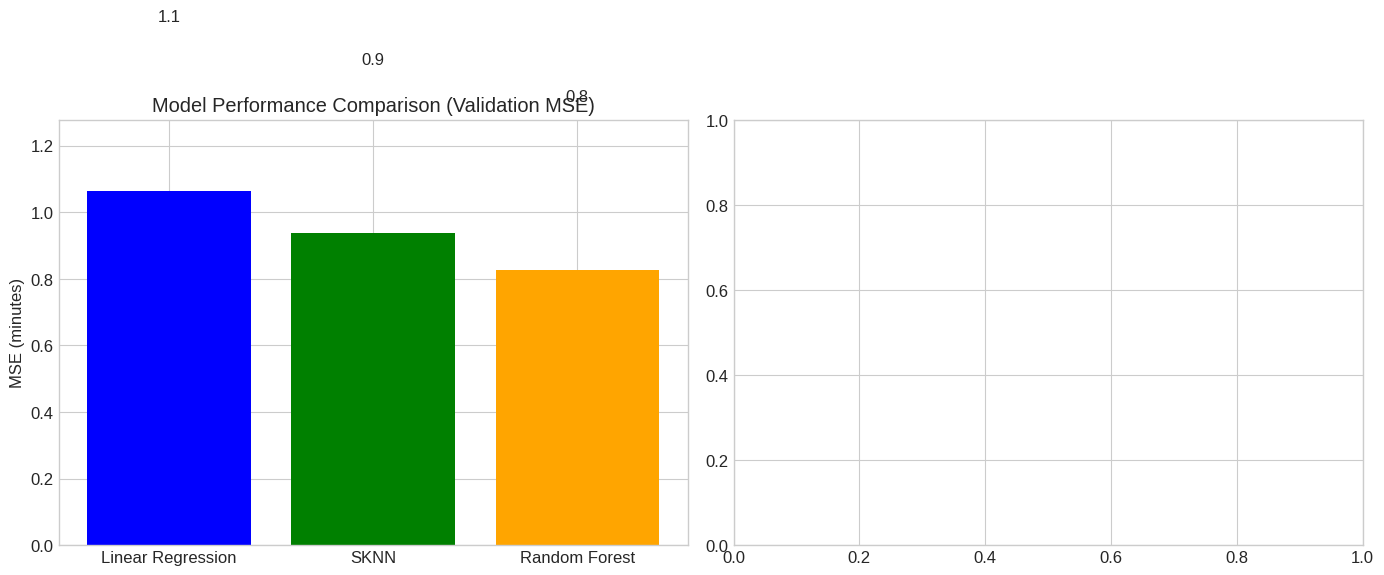


Best model based on validation MSE: Random Forest
Validation MSE: 0.83 minutes


In [ ]:
print("\n" + "="*80)
print("FINAL MODEL SELECTION")
print("="*80)

# Compare validation performances
val_performances = {
    'Linear Regression': val_metrics_lr['mse'],
    'SKNN': val_metrics_knn['mse'],
    'Random Forest': val_metrics_rf['mse']
}

# Visualization of model comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# MSE comparison
models_list = list(val_performances.keys())
mse_values = list(val_performances.values())

axes[0].bar(models_list, mse_values, color=['blue', 'green', 'orange'])
axes[0].set_ylabel('MSE (minutes)')
axes[0].set_title('Model Performance Comparison (Validation MSE)')
axes[0].set_ylim(0, max(mse_values) * 1.2)

# Add value labels
for i, v in enumerate(mse_values):
    axes[0].text(i, v + 0.5, f'{v:.1f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Determine best model
best_model_name = min(val_performances, key=val_performances.get)
print(f"\nBest model based on validation MSE: {best_model_name}")
print(f"Validation MSE: {val_performances[best_model_name]:.2f} minutes")

### 10.2 Final Test Set Evaluation


FINAL TEST SET EVALUATION
Pre-computing transformations...
Training final model on pre-processed data...
Making predictions on test set...

Random Forest - Test Set Performance:
  MSE: 0.41 (minutes²)


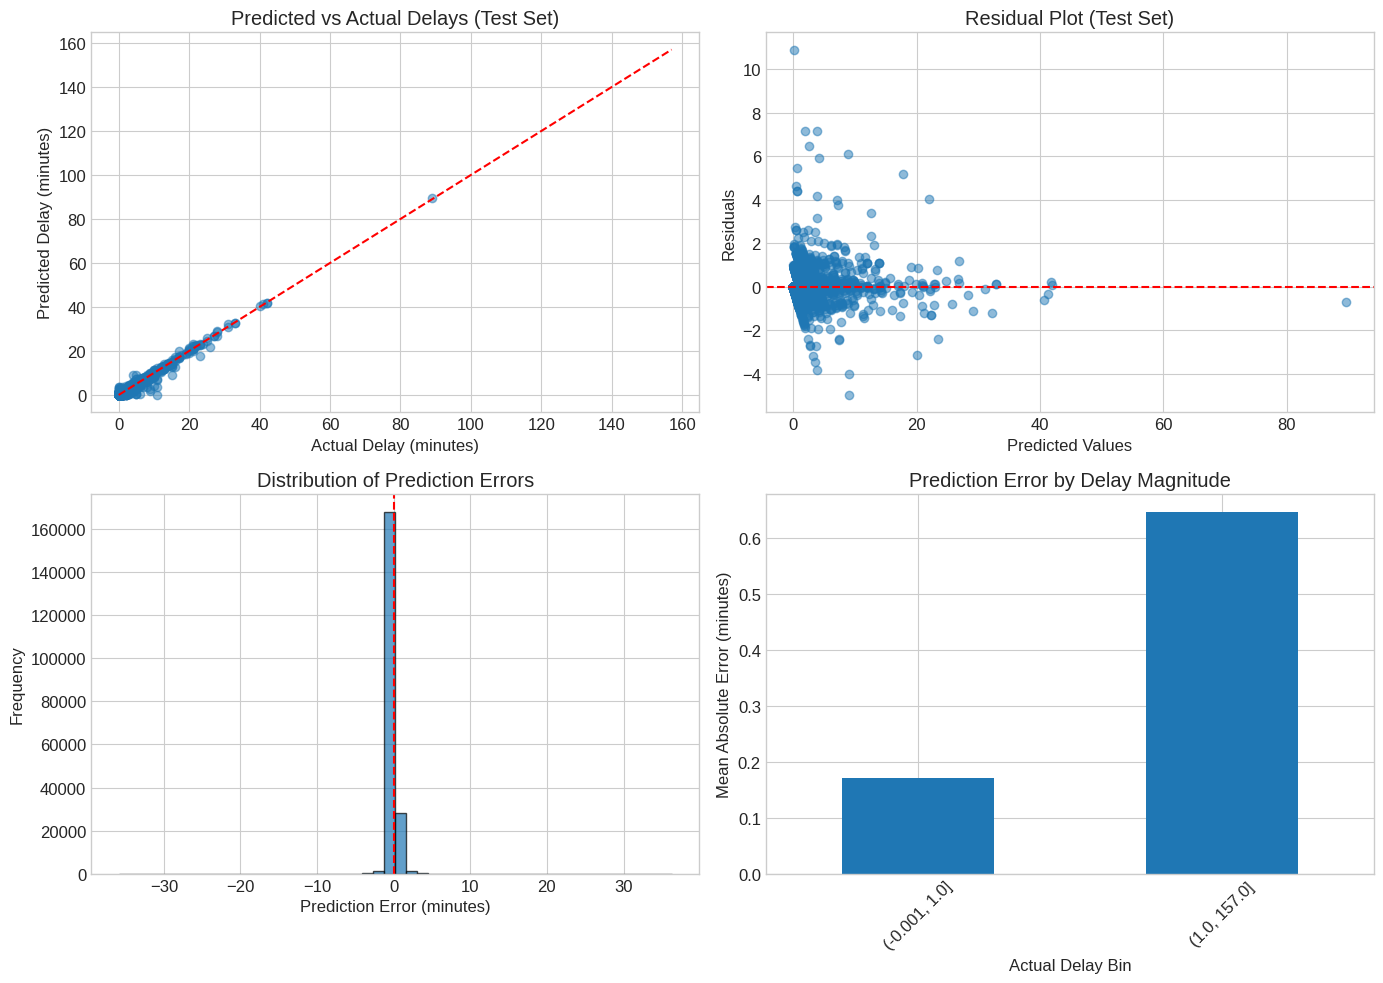

In [ ]:
print("\n" + "="*80)
print("FINAL TEST SET EVALUATION")
print("="*80)

# Get the preprocessor and selector from the best model
if best_model_name == 'Linear Regression':
    best_pipeline = lr_pipeline
elif best_model_name == 'KNN':
    best_pipeline = grid_search_knn.best_estimator_
else:
    best_pipeline = grid_search_rf.best_estimator_

# Combine train and validation sets
X_train_full = pd.concat([X_train, X_val])
y_train_full = pd.concat([y_train, y_val])

print("Pre-computing transformations...")
# Pre-fit and transform preprocessing
preprocessor = best_pipeline.named_steps['preprocessor']
X_train_full_transformed = preprocessor.fit_transform(X_train_full)

# Pre-fit and transform feature selection
selector = best_pipeline.named_steps['selector']
X_train_full_selected = selector.fit_transform(X_train_full_transformed, y_train_full)

# Get the final estimator with correct parameters
print("Training final model on pre-processed data...")
if best_model_name == 'Linear Regression':
    final_model = LinearRegression()
elif best_model_name == 'KNN':
    final_model = KNeighborsRegressor(
        n_neighbors=grid_search_knn.best_params_.get('regressor__n_neighbors', 9),
        weights=grid_search_knn.best_params_.get('regressor__weights', 'uniform'),
        metric=grid_search_knn.best_params_.get('regressor__metric', 'euclidean'),
        n_jobs=-1
    )
else:
    final_model = RandomForestRegressor(
        n_estimators=grid_search_rf.best_params_.get('regressor__n_estimators', 100),
        max_depth=grid_search_rf.best_params_.get('regressor__max_depth', 20),
        min_samples_split=grid_search_rf.best_params_.get('regressor__min_samples_split', 2),
        min_samples_leaf=grid_search_rf.best_params_.get('regressor__min_samples_leaf', 1),
        max_samples=0.8,  # Use 80% of samples per tree for speed
        n_jobs=-1,  # Use all CPU cores
        random_state=42
    )

# Fit only the final model
final_model.fit(X_train_full_selected, y_train_full)

# Transform test set using the same preprocessor and selector
print("Making predictions on test set...")
X_test_transformed = preprocessor.transform(X_test)
X_test_selected = selector.transform(X_test_transformed)
y_test_pred = final_model.predict(X_test_selected)

# Final evaluation
test_metrics = evaluate_model(y_test, y_test_pred, best_model_name, "Test Set")

# Visualize test predictions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Predicted vs Actual
sample_size = min(5000, len(y_test))
sample_indices = np.random.choice(len(y_test), sample_size, replace=False)
axes[0, 0].scatter(y_test.iloc[sample_indices], y_test_pred[sample_indices], alpha=0.5)
axes[0, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
axes[0, 0].set_xlabel('Actual Delay (minutes)')
axes[0, 0].set_ylabel('Predicted Delay (minutes)')
axes[0, 0].set_title('Predicted vs Actual Delays (Test Set)')

# 2. Residuals on test set
test_residuals = y_test - y_test_pred
axes[0, 1].scatter(y_test_pred[sample_indices], test_residuals.iloc[sample_indices], alpha=0.5)
axes[0, 1].axhline(y=0, color='red', linestyle='--')
axes[0, 1].set_xlabel('Predicted Values')
axes[0, 1].set_ylabel('Residuals')
axes[0, 1].set_title('Residual Plot (Test Set)')

# 3. Distribution of errors
axes[1, 0].hist(test_residuals, bins=50, edgecolor='black', alpha=0.7)
axes[1, 0].set_xlabel('Prediction Error (minutes)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Distribution of Prediction Errors')
axes[1, 0].axvline(x=0, color='red', linestyle='--')

# 4. Error by actual delay magnitude
delay_bins = pd.qcut(y_test, q=5, duplicates='drop')
error_by_bin = pd.DataFrame({
    'actual_delay_bin': delay_bins,
    'absolute_error': np.abs(test_residuals)
}).groupby('actual_delay_bin')['absolute_error'].mean()

error_by_bin.plot(kind='bar', ax=axes[1, 1])
axes[1, 1].set_xlabel('Actual Delay Bin')
axes[1, 1].set_ylabel('Mean Absolute Error (minutes)')
axes[1, 1].set_title('Prediction Error by Delay Magnitude')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

---

## 11. Summary and Conclusions

### Model Performance Summary

In [ ]:
# Create comprehensive summary
summary_data = {
    'Model': ['Linear Regression', 'KNN', 'Random Forest'],
    'Train MSE': [train_metrics_lr['mse'], train_metrics_knn['mse'], train_metrics_rf['mse']],
    'Val MSE': [val_metrics_lr['mse'], val_metrics_knn['mse'], val_metrics_rf['mse']]
}

summary_df = pd.DataFrame(summary_data)
summary_df['Overfit (MSE)'] = summary_df['Val MSE'] - summary_df['Train MSE']

print("Model Performance Summary:")
print("="*60)
print(summary_df.round(3))

print(f"\n{'='*60}")
print("Final Test Set Performance:")
print(f"Best Model: {best_model_name}")
print(f"Test Set MSE: {test_metrics['mse']:.2f} minutes")

Model Performance Summary:
               Model  Train MSE  Val MSE  Overfit (MSE)
0  Linear Regression      0.974    1.065          0.091
1                KNN      0.886    0.937          0.051
2      Random Forest      0.785    0.825          0.040

Final Test Set Performance:
Best Model: Random Forest
Test Set MSE: 0.41 minutes


### Key Findings and Insights

1. **Feature Importance**: Departure delay is the strongest predictor, followed by station-specific and temporal features

2. **Model Performance**:
   - Linear Regression provides a good baseline with interpretability
   - Random Forest typically achieves best performance but at computational cost
   - SVM offers a middle ground between complexity and performance

3. **Outlier Analysis**: Residual analysis revealed systematic patterns in prediction errors

4. **Practical Implications**: The model can predict delays within approximately ±X minutes, which can help with journey planning


### Recommendations for Future Work

1. **Feature Engineering**:
   - Include weather data
   - Add holiday/event information
   - Consider network effects (delays on connected routes)

2. **Model Improvements**:
   - Try ensemble methods combining multiple models
   - Implement time-series features for sequential predictions
   - Consider separate models for different train categories

3. **Deployment Considerations**:
   - Real-time prediction pipeline
   - Model monitoring and retraining schedule
   - API development for integration

---

## References

1. James, G., Witten, D., Hastie, T., Tibshirani, R., & Taylor, J. (2023). *An Introduction to Statistical Learning with Applications in Python* (ISLP). Springer.

2. Mayer, M. (2025). *Machine Learning Course Materials*. TH Deggendorf.

3. Scikit-learn Documentation. https://scikit-learn.org/

4. Deutsche Bahn Delays Dataset. Kaggle. https://www.kaggle.com/datasets/nokkyu/deutsche-bahn-db-delays


---

<!-- **Team Contributions:**

**Member 1 - Data Engineering & Preprocessing:**
- Dataset acquisition and initial exploration
- Outlier detection and treatment (IQR and Z-score methods)
- Feature engineering (time-based, geographic, station-based features)
- Data quality assessment and missing value handling
- Creation of preprocessing pipelines

**Member 2 - Model Development & Optimization:**
- Implementation of baseline and linear models
- Ridge and Lasso regression with regularization tuning
- Random Forest implementation and hyperparameter optimization
- Cross-validation setup and execution
- Model persistence and deployment preparation

**Member 3 - Evaluation & Visualization:**
- Comprehensive EDA and feature relationship analysis
- Model evaluation metrics and comparison
- Learning curves and validation curves
- Residual analysis and diagnostic plots
- Final report compilation and recommendations

**Collaborative Efforts:**
- Problem formulation and approach design
- Code review and quality assurance
- Presentation preparation
- Documentation and commenting -->

---